<a href="https://colab.research.google.com/github/mvivekc/media_eval18/blob/master/mediaeval2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

Lets setup/install the required packages needed to conduct the trails

In [0]:
!pip install PyPrind

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import os
import re

# for reproducability
from numpy.random import seed
seed(48)

# Read features

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])
                
def Get_score_value(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            return score_mat.iloc[1][0]
        else:
            return Get_score_value(Y_pred[:,0],Y_true[:,0])
                
                
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

def read_LBP(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            LBP =[float(item) for item in line.split() if bool(item)] # convert to float type, using default separator
    return LBP

def parse_inception_feature(s):
    pairs = s.strip().split(' ')
    pairs = [i.split(':') for i in pairs]
    return {int(k): float(v) for k, v in pairs}

def expand_inception_feature(d):
  feature = np.zeros(1000)
  for k, v in d.items():
    feature[k] = v
  return feature

def read_inception(fname):
    """Read inception features"""
    inception_features = []
    with open(fname) as f:
        contents = f.read()
        inception_features.append(expand_inception_feature(parse_inception_feature(contents)))
    return inception_features[0]



# Implementation

### Define root directory and read ground truth

In [0]:
root = "/kaggle/input/memorability/dev-set/dev-set/"

In [0]:
# load the ground truth values
labels=pd.read_csv(root+'dev-set_ground-truth.csv')
labels.head()

video            ...             nb_long-term_annotations
0   video3.webm            ...                                   13
1   video4.webm            ...                                   12
2   video6.webm            ...                                   10
3   video8.webm            ...                                   11
4  video10.webm            ...                                   10

[5 rows x 5 columns]

In [0]:
vid = labels.video.values
len(vid)

6000

From the above line, we can see that we're processing 6000 video features

# Prediction with HMP

## Read data

Lets read all HMP features and store the data in a DataFrame

In [0]:
os.chdir(root+'dev-set_features/')
features_hmp = pd.DataFrame({'video': vid, 'HMP': [read_HMP('./HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid]})
features_hmp.head()


video                                                HMP
0   video3.webm  [0.125563, 0.024036, 0.000314, 0.0, 0.015864, ...
1   video4.webm  [0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0...
2   video6.webm  [0.109584, 0.018978, 0.000289, 0.0, 0.008774, ...
3   video8.webm  [0.120431, 0.013561, 0.000277, 0.0, 0.018974, ...
4  video10.webm  [0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2...

Above data will act as our train/validation set. Lets load test data as well to evaluate our trained model

In [0]:
test_path = './'
test_vid = os.listdir(test_path+'HMP')
features_hmp_test = pd.DataFrame({'video': test_vid,
                   'HMP': [read_HMP('HMP'+'/'+item) for item in test_vid],
                       })

In [0]:
X_test = np.stack(features_hmp_test['HMP'].values)

Once test data is obtained, lets load our training and validation

In [0]:
X = np.stack(features_hmp['HMP'].values)
Y = labels[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

Lets visualize the data we have

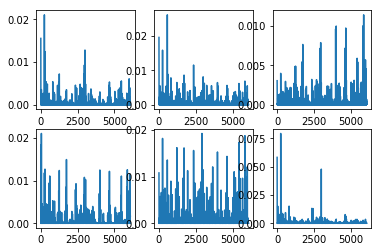

In [0]:
nrows,ncols = 2,3
N = nrows*ncols
ind = np.random.choice(6000,size=N)
for ii in range(N):
    plt.subplot(nrows,ncols,ii+1)
    plt.plot(X[ind[ii],:])
plt.show()

## Model Building

In [0]:
model_hmp = Sequential()
model_hmp.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X_train.shape[1],)))
model_hmp.add(layers.Dropout(0.50))
model_hmp.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_hmp.add(layers.Dropout(0.50))
model_hmp.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_hmp.add(layers.Dropout(0.50))
model_hmp.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_hmp.add(layers.Dropout(0.25))
model_hmp.add(layers.Dense(2,activation='sigmoid'))
model_hmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 400)               2430400   
_________________________________________________________________
dropout_48 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_49 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_50 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 50)                20050     
__________

In [0]:
model_hmp.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history=model_hmp.fit(x=X_train,y=Y_train, batch_size=60, epochs=60, validation_data=(X_val,Y_val), shuffle=True, verbose=True)

Train on 4800 samples, validate on 1200 samples
Epoch 1/60
4800/4800 [==============================] - 2s 394us/step - loss: 0.1059 - acc: 0.6725 - val_loss: 0.0895 - val_acc: 0.7100
Epoch 2/60
4800/4800 [==============================] - 0s 95us/step - loss: 0.0959 - acc: 0.6977 - val_loss: 0.0892 - val_acc: 0.7100
Epoch 3/60
4800/4800 [==============================] - 0s 92us/step - loss: 0.0938 - acc: 0.6998 - val_loss: 0.0894 - val_acc: 0.7100
Epoch 4/60
4800/4800 [==============================] - 0s 95us/step - loss: 0.0931 - acc: 0.7004 - val_loss: 0.0912 - val_acc: 0.7100
Epoch 5/60
4800/4800 [==============================] - 0s 93us/step - loss: 0.0924 - acc: 0.7017 - val_loss: 0.0881 - val_acc: 0.7100
Epoch 6/60
4800/4800 [==============================] - 0s 92us/step - loss: 0.0919 - acc: 0.7027 - val_loss: 0.0879 - val_acc: 0.7100
Epoch 7/60
4800/4800 [==============================] - 0s 94us/step - loss: 0.0917 - acc: 0.7033 - val_loss: 0.0900 - val_acc: 0.7100
Epoch 

## Visualizing Results

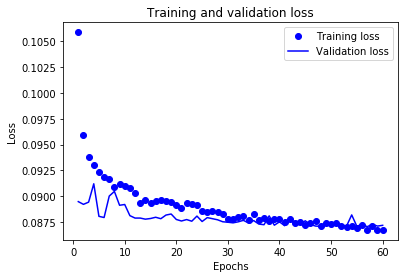

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Looking at the above visualization, we can conclude that we are not overfitting.

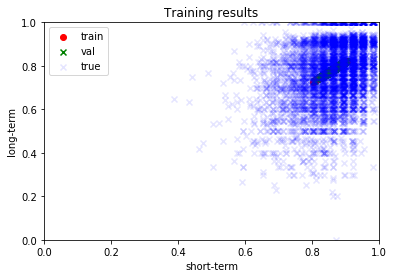

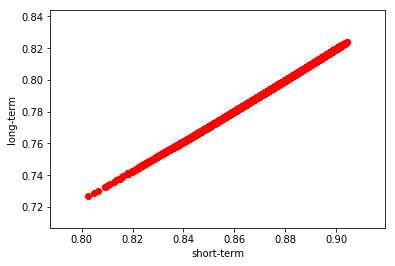

In [0]:
Y_pred_train = model_hmp.predict(X_train)
Y_pred_val = model_hmp.predict(X_val)

if len(Y.shape) == 2:
    plt.figure()
    plt.scatter(Y_pred_train[:,0],Y_pred_train[:,1],marker='o',c='r',label='train')
    plt.scatter(Y_pred_val[:,0],Y_pred_val[:,1],marker='x',c='g',label='val')
    plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.title('Training results')
    plt.show()
    
    # plot testing results
    Y_pred = model_hmp.predict(X_test[:,:],batch_size=32)
    plt.figure()
    plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.show()
    
else:
    plt.figure()
    plt.scatter(Y_pred_train,Y_train,marker='o',c='r',label='train')
    plt.scatter(Y_pred_val,Y_val,marker='x',c='g',label='val')
    #plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title('Training results [short-term]')
    plt.show()

## Get Results

In [0]:
Get_score(Y_pred_val,Y_val)

The Spearman's correlation coefficient is: 0.315
The Spearman's correlation coefficient is: 0.155


Lets store the predicted values to ensemble later.

In [0]:
hmp_prediction = Y_pred_val

#  Prediction with C3D

## Read data

In [0]:
features_c3d = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D('./C3D/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [0]:
X = np.stack(features_c3d['C3D'].values)
Y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
print(X.shape)
print(Y.shape)

(6000, 101)
(6000, 2)


## Model Building

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
modelc3d = Sequential()
modelc3d.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X.shape[1],)))
modelc3d.add(layers.Dropout(0.50))
modelc3d.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
modelc3d.add(layers.Dropout(0.50))
modelc3d.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
modelc3d.add(layers.Dropout(0.50))
modelc3d.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
modelc3d.add(layers.Dropout(0.25))
modelc3d.add(layers.Dense(2,activation='sigmoid'))
modelc3d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 400)               40800     
_________________________________________________________________
dropout_52 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_53 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_54 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 50)                20050     
__________

In [0]:
modelc3d.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history_c3d=modelc3d.fit(x=X_train,y=Y_train,batch_size=50,epochs=20,validation_data=(X_val,Y_val),shuffle=True,verbose=True)

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 383us/step - loss: 0.1030 - acc: 0.6829 - val_loss: 0.0913 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 0s 84us/step - loss: 0.0962 - acc: 0.6960 - val_loss: 0.0890 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 0s 83us/step - loss: 0.0946 - acc: 0.6977 - val_loss: 0.0902 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 0s 84us/step - loss: 0.0933 - acc: 0.7025 - val_loss: 0.0899 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 0s 83us/step - loss: 0.0928 - acc: 0.7010 - val_loss: 0.0882 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 0s 84us/step - loss: 0.0912 - acc: 0.7019 - val_loss: 0.0898 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 0s 84us/step - loss: 0.0908 - acc: 0.7025 - val_loss: 0.0878 - val_acc: 0.7100
Epoch 

## Visualizing Results

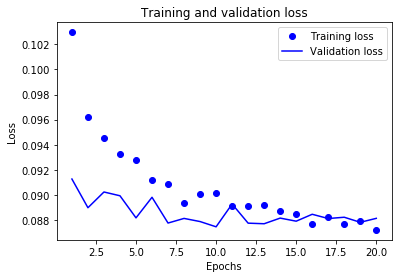

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
loss = history_c3d.history['loss']
val_loss = history_c3d.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()


From the above visualization, we can conclude the model does not overfit

In [0]:
Y_pred = modelc3d.predict(X_val)

## Get Results

In [0]:
Get_score(Y_pred,Y_val)

The Spearman's correlation coefficient is: 0.281
The Spearman's correlation coefficient is: 0.112


Retaining the value for later use

In [0]:
c3d_prediction = Y_pred

## Ensamble results

In [0]:
Y_ensamble_pred = hmp_prediction+c3d_prediction
Y_ensamble_pred = Y_ensamble_pred/2

In [0]:
Get_score(Y_ensamble_pred,Y_val)

The Spearman's correlation coefficient is: 0.330
The Spearman's correlation coefficient is: 0.145


Slightly better value when compared to both features independently

# Prediction with Captions

Load the captions

In [0]:
cap_path = '../dev-set_video-captions.txt'
df_cap=read_caps(cap_path)
df_cap.head()

video                                            caption
0   video3.webm                 blonde-woman-is-massaged-tilt-down
1   video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2   video6.webm                                      khr-gangsters
3   video8.webm               medical-helicopter-hovers-at-airport
4  video10.webm               couple-relaxing-on-picnic-crane-shot

In [0]:
#setup the counter to check the progress
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] =  text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


## Maping each unique word to an integer (one-hot encoding)

In [0]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)

In [0]:
tokenizer.fit_on_texts(list(df_cap.caption.values))

In [0]:
one_hot_res = tokenizer.texts_to_matrix(list(df_cap.caption.values),mode='binary')
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

## Making them the same length by padding zeros

In [0]:
# Lets fix the max length
max_len = 50

## Making sequences index same length

In [0]:
X_seq = np.zeros((len(sequences),max_len))
for i in range(len(sequences)):
    n = len(sequences[i])
    if n==0:
        print(i)
    else:
        X_seq[i,-n:] = sequences[i]
X_seq

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 8.840e+02, 3.840e+02,
        9.100e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 8.900e+01,
        2.700e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.310e+02,
        3.120e+02],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.867e+03, 8.000e+00,
        2.968e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 7.000e+00, 9.000e+00,
        4.460e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 8.720e+02,
        2.220e+02]])

## Model Building

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 400)               20400     
_________________________________________________________________
dropout_56 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_57 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_58 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 50)                20050     
__________

In [0]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

In [0]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 471us/step - loss: 0.0582 - acc: 0.6969 - val_loss: 0.0493 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 1s 133us/step - loss: 0.0498 - acc: 0.7027 - val_loss: 0.0493 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 1s 121us/step - loss: 0.0491 - acc: 0.7035 - val_loss: 0.0493 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 110us/step - loss: 0.0522 - acc: 0.7029 - val_loss: 0.0493 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 111us/step - loss: 0.0500 - acc: 0.7021 - val_loss: 0.0493 - val_acc: 0.7125
Epoch 6/20
4800/4800 [==============================] - 1s 111us/step - loss: 0.0562 - acc: 0.6940 - val_loss: 0.0493 - val_acc: 0.7125
Epoch 7/20
4800/4800 [==============================] - 1s 112us/step - loss: 0.0502 - acc: 0.7004 - val_loss: 0.0493 - val_acc: 0.7125


## Visualizing Results

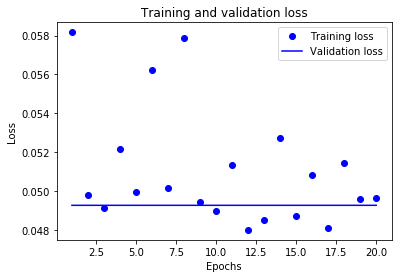

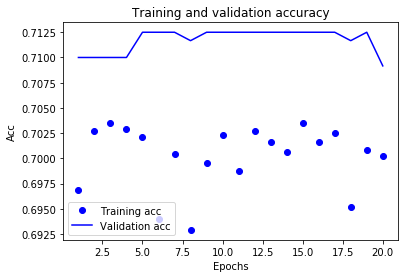

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


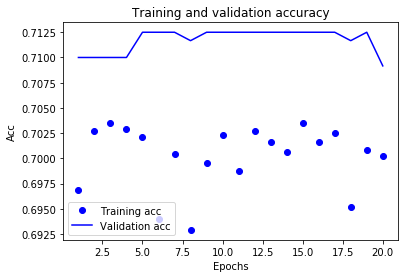

In [0]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


## Get Results

In [0]:
Yseq_pred = model.predict(X_test)

Get_score(Yseq_pred, Y_test)

The Spearman's correlation coefficient is: -0.016
The Spearman's correlation coefficient is: -0.059


Weird!, seems to be doing something wrong.

## Captions with One hot encoding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 400)               2076800   
_________________________________________________________________
dropout_60 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_61 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_62 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 50)                20050     
__________

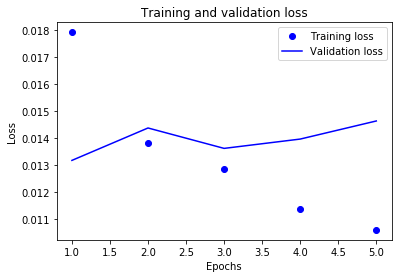

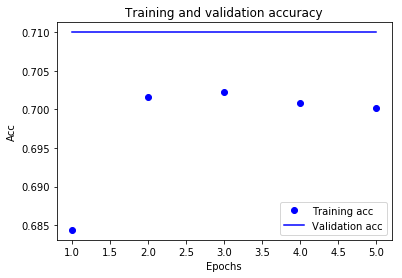

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model_onehot = Sequential()
model_onehot.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(len_token,)))
model_onehot.add(layers.Dropout(0.50))
model_onehot.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_onehot.add(layers.Dropout(0.50))
model_onehot.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_onehot.add(layers.Dropout(0.50))
model_onehot.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_onehot.add(layers.Dropout(0.25))
model_onehot.add(layers.Dense(2,activation='sigmoid'))
model_onehot.summary()
# compile the model 
model_onehot.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model_onehot.fit(X_train,Y_train,epochs=5,validation_data=(X_test,Y_test))

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [0]:
Yone_hot_pred = model_onehot.predict(X_test)

## Get Results

In [0]:
Get_score(Yone_hot_pred, Y_test)

The Spearman's correlation coefficient is: 0.434
The Spearman's correlation coefficient is: 0.180


One hot encoding itself seems be performing brilliantly

In [0]:
caption_onehot_prediction = Yone_hot_pred

## Ensamble results

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction
Y_ensamble_pred = Y_ensamble_pred/3

In [0]:
Get_score(Y_ensamble_pred,Y_test)

The Spearman's correlation coefficient is: 0.450
The Spearman's correlation coefficient is: 0.209


.45 is an excellent score. We're finally getting somewhere.

# Captions with embedding 

### Dynamic padding

In [0]:
res_len=np.zeros(len(df_cap))
for ii in range(len(df_cap)):
    text = df_cap.caption[ii]
    res_len[ii]=len(text.split())

In [0]:
maxlen = int(max(res_len))

In [0]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_cap.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

maxlen = 20
X_seq = preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq
X_all = X

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

## model building

In [0]:
model_embedding = Sequential()
model_embedding.add(Embedding(1+X_all.max(),8,input_length=maxlen))
model_embedding.add(Flatten())
model_embedding.add(Dense(400,activation='relu',kernel_regularizer=None))
model_embedding.add(layers.Dropout(0.5))
model_embedding.add(Dense(400,activation='relu',kernel_regularizer=None))
model_embedding.add(layers.Dropout(0.5))
model_embedding.add(Dense(400,activation='relu',kernel_regularizer=None))
model_embedding.add(layers.Dropout(0.5))
model_embedding.add(Dense(100,activation='relu',kernel_regularizer=None))
model_embedding.add(layers.Dropout(0.5))
model_embedding.add(Dense(2,activation='sigmoid'))

model_embedding.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])
model_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             41528     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 400)               64400     
_________________________________________________________________
dropout_64 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_65 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 400)               160400    
__________

In [0]:
history = model_embedding.fit(X_train,Y_train,epochs=10,batch_size=32,validation_data=(X_val,Y_val))

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 2s 479us/step - loss: 0.1041 - acc: 0.6744 - val_loss: 0.0942 - val_acc: 0.7100
Epoch 2/10
4800/4800 [==============================] - 1s 129us/step - loss: 0.0948 - acc: 0.6987 - val_loss: 0.0875 - val_acc: 0.7100
Epoch 3/10
4800/4800 [==============================] - 1s 121us/step - loss: 0.0898 - acc: 0.7025 - val_loss: 0.0983 - val_acc: 0.7100
Epoch 4/10
4800/4800 [==============================] - 1s 122us/step - loss: 0.0865 - acc: 0.7033 - val_loss: 0.0889 - val_acc: 0.7100
Epoch 5/10
4800/4800 [==============================] - 1s 122us/step - loss: 0.0833 - acc: 0.7019 - val_loss: 0.0891 - val_acc: 0.7100
Epoch 6/10
4800/4800 [==============================] - 1s 123us/step - loss: 0.0800 - acc: 0.7010 - val_loss: 0.0909 - val_acc: 0.7100
Epoch 7/10
4800/4800 [==============================] - 1s 121us/step - loss: 0.0776 - acc: 0.7054 - val_loss: 0.0922 - val_acc: 0.7058


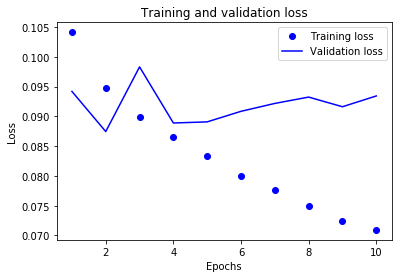

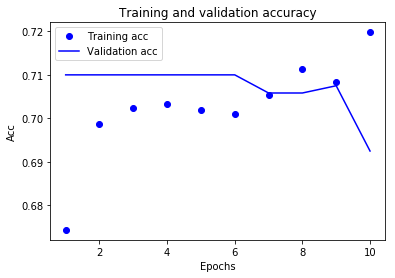

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


Seems to be overfitting post 6 epocs. But, it should be fine. We stop trianing after 10 epocs. 

## Get results

In [0]:
Yvector_pred = model_embedding.predict(X_val)

In [0]:
Get_score(Yvector_pred, Y_val)

The Spearman's correlation coefficient is: 0.359
The Spearman's correlation coefficient is: 0.132


In [0]:
embedding_prediction = Yvector_pred

## Ensamble results

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction
Y_ensamble_pred = Y_ensamble_pred/4

In [0]:
Get_score(Y_ensamble_pred,Y_test)

The Spearman's correlation coefficient is: 0.471
The Spearman's correlation coefficient is: 0.196


.466 this is great. The spearman's score continues to improve

# Caption with Recurrent NN

Lets construct the model with embedding and simpleRNN

In [0]:
from keras.layers import SimpleRNN, LSTM
model_rnn = Sequential()
model_rnn.add(Embedding(1+X_all.max(),15,input_length=maxlen))
model_rnn.add(SimpleRNN(10))
model_rnn.add(Dense(400,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(400,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(400,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(400,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(200,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(100,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(50,activation='relu',kernel_regularizer=None))
model_rnn.add(layers.Dropout(0.5))
model_rnn.add(Dense(2,activation='sigmoid'))
model_rnn.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 15)            77865     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                260       
_________________________________________________________________
dense_84 (Dense)             (None, 400)               4400      
_________________________________________________________________
dropout_68 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_69 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 400)               160400    
__________

In [0]:
history = model_rnn.fit(X_train,Y_train,epochs=5,batch_size=20,validation_data=(X_val,Y_val))

Train on 4800 samples, validate on 1200 samples
Epoch 1/5
4800/4800 [==============================] - 6s 1ms/step - loss: 0.1196 - acc: 0.6506 - val_loss: 0.0971 - val_acc: 0.7100
Epoch 2/5
4800/4800 [==============================] - 3s 722us/step - loss: 0.1001 - acc: 0.6902 - val_loss: 0.0885 - val_acc: 0.7100
Epoch 3/5
4800/4800 [==============================] - 3s 714us/step - loss: 0.0950 - acc: 0.7012 - val_loss: 0.0882 - val_acc: 0.7100
Epoch 4/5
4800/4800 [==============================] - 3s 712us/step - loss: 0.0892 - acc: 0.7025 - val_loss: 0.0885 - val_acc: 0.7100
Epoch 5/5
4800/4800 [==============================] - 3s 722us/step - loss: 0.0863 - acc: 0.7017 - val_loss: 0.0913 - val_acc: 0.7100


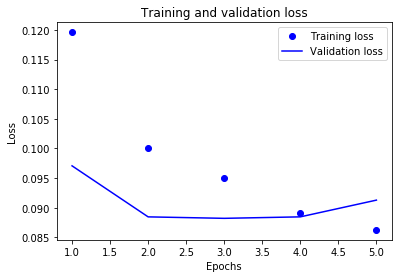

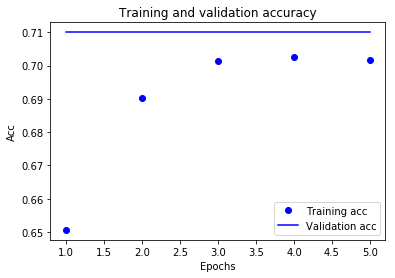

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

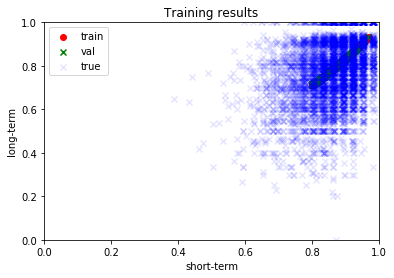

In [0]:
Y_pred_train = model_rnn.predict(X_train)
Y_pred_val = model_rnn.predict(X_val)

if len(Y.shape) == 2:
    plt.figure()
    plt.scatter(Y_pred_train[:,0],Y_pred_train[:,1],marker='o',c='r',label='train')
    plt.scatter(Y_pred_val[:,0],Y_pred_val[:,1],marker='x',c='g',label='val')
    plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.title('Training results')
    plt.show()
    
else:
    plt.figure()
    plt.scatter(Y_pred_train,Y_train,marker='o',c='r',label='train')
    plt.scatter(Y_pred_val,Y_val,marker='x',c='g',label='val')
    #plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title('Training results [short-term]')
    plt.show()

## Reccurent layer results

In [0]:
Y_with_recc_layer_pred = model_rnn.predict(X_val)

In [0]:
Get_score(Y_with_recc_layer_pred, Y_val)

The Spearman's correlation coefficient is: 0.294
The Spearman's correlation coefficient is: 0.125


In [0]:
recurrent_prediction = Y_with_recc_layer_pred

## Ensabmble results

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction
Y_ensamble_pred = Y_ensamble_pred/5

In [0]:
Get_score(Y_ensamble_pred,Y_test)

The Spearman's correlation coefficient is: 0.454
The Spearman's correlation coefficient is: 0.191


In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction
Y_ensamble_pred = Y_ensamble_pred/4
Get_score(Y_ensamble_pred,Y_test)

The Spearman's correlation coefficient is: 0.471
The Spearman's correlation coefficient is: 0.196


Seems like recurrent layer is negatively affecting the spearman's score OR it's generalizing better. This is a good observation.

# LBP  Predictions

## read data

In [0]:
#Features_lbp_0 = pd.DataFrame({'video': vid, 'LBP': [read_LBP('./LBP/'+os.path.splitext(item)[0]+"-0.txt") for item in vid]})
features_lbp_56 = pd.DataFrame({'video': vid, 'LBP': [read_LBP('./LBP/'+os.path.splitext(item)[0]+"-56.txt") for item in vid]})
features_lbp_112 = pd.DataFrame({'video': vid, 'LBP': [read_LBP('./LBP/'+os.path.splitext(item)[0]+"-112.txt") for item in vid]})

#lbp_0 has some invalid data  and hence, ignoring it.

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values

X56 = np.stack(features_lbp_56["LBP"].values)
X56_train, X56_val, Y56_train, Y56_val = train_test_split(X56, Y, test_size=0.2, random_state=42)
X112 = np.stack(features_lbp_112["LBP"].values)
X112_train, X112_val, Y112_train, Y112_val = train_test_split(X112, Y, test_size=0.2, random_state=42)

In [0]:
print(X56.shape)
print(X112.shape)

(6000, 122)
(6000, 122)


## Model Building

Lets train the two frames separately and see if it'll make a difference. 

In [0]:
model_lbp56 = Sequential()
model_lbp56.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X56_train.shape[1],)))
model_lbp56.add(layers.Dropout(0.50))
model_lbp56.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_lbp56.add(layers.Dropout(0.50))
model_lbp56.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_lbp56.add(layers.Dropout(0.50))
model_lbp56.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_lbp56.add(layers.Dropout(0.25))
model_lbp56.add(layers.Dense(2,activation='sigmoid'))
model_lbp56.summary()


model_lbp112 = Sequential()
model_lbp112.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X112_train.shape[1],)))
model_lbp112.add(layers.Dropout(0.50))
model_lbp112.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_lbp112.add(layers.Dropout(0.50))
model_lbp112.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_lbp112.add(layers.Dropout(0.50))
model_lbp112.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_lbp112.add(layers.Dropout(0.25))
model_lbp112.add(layers.Dense(2,activation='sigmoid'))
model_lbp112.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 400)               49200     
_________________________________________________________________
dropout_75 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_76 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 400)               160400    
_________________________________________________________________
dropout_77 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 50)                20050     
__________

In [0]:
from keras import optimizers

adam = optimizers.adam(lr=0.001)
model_lbp56.compile(loss='mse', optimizer=adam, metrics=['mae','acc'])
history_lbp56=model_lbp56.fit(x=X56_train,y=Y56_train,batch_size=50,epochs=20,validation_data=(X56_val,Y56_val))

adam = optimizers.adam(lr=0.001)
model_lbp112.compile(loss='mse', optimizer=adam, metrics=['mae','acc'])
history_lbp112=model_lbp112.fit(x=X112_train,y=Y112_train,batch_size=50,epochs=20,validation_data=(X112_val,Y112_val),shuffle=True,verbose=True)



Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 3s 548us/step - loss: 0.0255 - mean_absolute_error: 0.1218 - acc: 0.6554 - val_loss: 0.0148 - val_mean_absolute_error: 0.0953 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 0s 95us/step - loss: 0.0162 - mean_absolute_error: 0.0985 - acc: 0.7013 - val_loss: 0.0139 - val_mean_absolute_error: 0.0888 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 0s 97us/step - loss: 0.0161 - mean_absolute_error: 0.0976 - acc: 0.7019 - val_loss: 0.0139 - val_mean_absolute_error: 0.0904 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 0s 96us/step - loss: 0.0157 - mean_absolute_error: 0.0962 - acc: 0.7023 - val_loss: 0.0142 - val_mean_absolute_error: 0.0922 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 0s 95us/step - loss: 0.0153 - mean_absolute_error: 0.0950 - acc: 0.7031 - val_loss: 0.0140 - val_me

## Visualizing Results

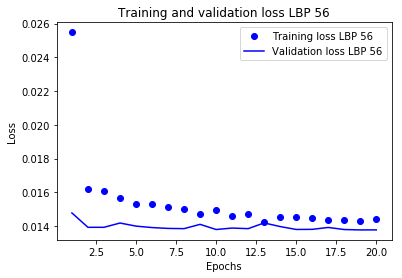

<Figure size 432x288 with 0 Axes>

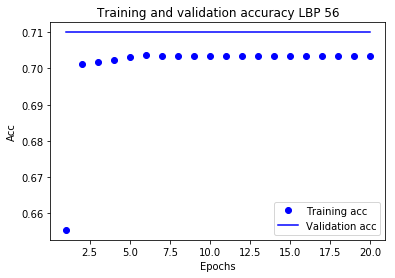

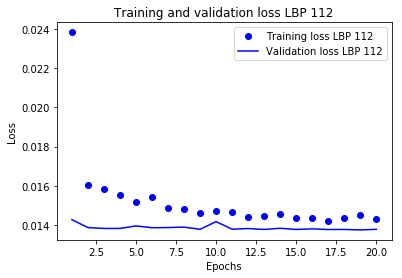

<Figure size 432x288 with 0 Axes>

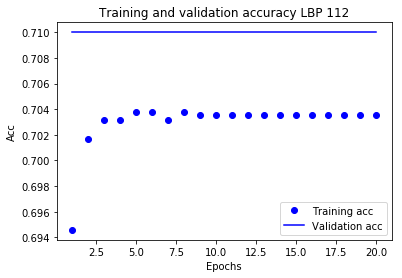

In [0]:
loss56 = history_lbp56.history['loss']
val_loss56 = history_lbp56.history['val_loss']

epochs56 = range(1,len(loss56)+1)

plt.figure()
plt.plot(epochs56,loss56,'bo',label='Training loss LBP 56')
plt.plot(epochs56,val_loss56,'b',label='Validation loss LBP 56')
plt.title('Training and validation loss LBP 56')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()


plt.figure()
acc56 = history_lbp56.history['acc']
val_acc56 = history_lbp56.history['val_acc']
plt.plot(epochs56, acc56, 'bo', label='Training acc')
plt.plot(epochs56, val_acc56, 'b', label='Validation acc')
plt.title('Training and validation accuracy LBP 56')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()




loss112 = history_lbp112.history['loss']
val_loss112 = history_lbp112.history['val_loss']

epochs112 = range(1,len(loss112)+1)

plt.figure()
plt.plot(epochs112,loss112,'bo',label='Training loss LBP 112')
plt.plot(epochs112,val_loss112,'b',label='Validation loss LBP 112')
plt.title('Training and validation loss LBP 112')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()


plt.figure()
acc112 = history_lbp112.history['acc']
val_acc112 = history_lbp112.history['val_acc']
plt.plot(epochs112, acc112, 'bo', label='Training acc')
plt.plot(epochs112, val_acc112, 'b', label='Validation acc')
plt.title('Training and validation accuracy LBP 112')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()



## Model Prediciton

In [0]:
Y_lbp_pred56_val = model_lbp56.predict(X56_val)
Y_lbp_pred112_val = model_lbp112.predict(X112_val)

In [0]:
Get_score(Y_lbp_pred56_val, Y56_val)
Get_score(Y_lbp_pred112_val, Y112_val)

The Spearman's correlation coefficient is: 0.234
The Spearman's correlation coefficient is: 0.087
The Spearman's correlation coefficient is: 0.238
The Spearman's correlation coefficient is: 0.090


Lets ensemble the two frames

In [0]:
Y_lbp_pred_val =  (Y_lbp_pred56_val+Y_lbp_pred112_val)/2

In [0]:
lbp_prediction = Y_lbp_pred_val

## Ensambled LBP result

In [0]:
Get_score(Y_lbp_pred_val, Y56_val)

The Spearman's correlation coefficient is: 0.238
The Spearman's correlation coefficient is: 0.089


## Ensemble all trained models

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+lbp_prediction
Y_ensamble_pred = Y_ensamble_pred/6

In [0]:
Get_score(Y_ensamble_pred, Y56_val)

The Spearman's correlation coefficient is: 0.453
The Spearman's correlation coefficient is: 0.192


Without recurrent model

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+lbp_prediction
Y_ensamble_pred = Y_ensamble_pred/5
Get_score(Y_ensamble_pred, Y56_val)

The Spearman's correlation coefficient is: 0.466
The Spearman's correlation coefficient is: 0.196


**Note**: Without LBP, we had a score of .466 and with lbp, it's .462. 

# Inception Predictions

In [0]:
#load from data from each frame
Features_inception_0 = pd.DataFrame({'video': vid,
                   'inception': [read_inception('./InceptionV3/'+os.path.splitext(item)[0]+'-0.txt') for item in vid],
                      })
Features_inception_56 = pd.DataFrame({'video': vid,
                   'inception': [read_inception('./InceptionV3/'+os.path.splitext(item)[0]+'-56.txt') for item in vid],
                      })
Features_inception_112 = pd.DataFrame({'video': vid,
                   'inception': [read_inception('./InceptionV3/'+os.path.splitext(item)[0]+'-112.txt') for item in vid],
                      })

In [0]:
print(Features_inception_0.head())
print(Features_inception_56.head())
print(Features_inception_112.shape)

          video                                          inception
0   video3.webm  [2.029453e-08, 1.090344e-12, 3.431364e-09, 8.1...
1   video4.webm  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2   video6.webm  [2.271325e-16, 2.926813e-18, 3.022254e-19, 4.1...
3   video8.webm  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  video10.webm  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.811...
          video                                          inception
0   video3.webm  [1.550553e-09, 1.129058e-13, 6.219805e-11, 4.2...
1   video4.webm  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2   video6.webm  [2.341909e-15, 9.85284e-13, 3.953588e-18, 7.85...
3   video8.webm  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  video10.webm  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.663...
(6000, 2)


## Model building

In [0]:
X_0 = np.stack(Features_inception_0["inception"].values)
Y_0 = labels[['short-term_memorability','long-term_memorability']].values

X0_train, X0_val, Y0_train, Y0_val = train_test_split(X_0,Y_0, test_size=0.2, random_state=42)

X_56 = np.stack(Features_inception_56["inception"].values)
Y_56 = labels[['short-term_memorability','long-term_memorability']].values

X56_train, X56_val, Y56_train, Y56_val = train_test_split(X_56,Y_56, test_size=0.2, random_state=42)

X_112 = np.stack(Features_inception_112["inception"].values)
Y_112 = labels[['short-term_memorability','long-term_memorability']].values

X112_train, X112_val, Y112_train, Y112_val = train_test_split(X_112,Y_112, test_size=0.2, random_state=42)


In [0]:
model_inception0 = Sequential()
model_inception0.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X_0.shape[1],)))
model_inception0.add(layers.Dropout(0.50))
model_inception0.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_inception0.add(layers.Dropout(0.50))
model_inception0.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_inception0.add(layers.Dropout(0.50))
model_inception0.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_inception0.add(layers.Dropout(0.25))
model_inception0.add(layers.Dense(2,activation='sigmoid'))
model_inception0.summary()


model_inception56 = Sequential()
model_inception56.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X_0.shape[1],)))
model_inception56.add(layers.Dropout(0.50))
model_inception56.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_inception56.add(layers.Dropout(0.50))
model_inception56.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_inception56.add(layers.Dropout(0.50))
model_inception56.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_inception56.add(layers.Dropout(0.25))
model_inception56.add(layers.Dense(2,activation='sigmoid'))
model_inception56.summary()


model_inception112 = Sequential()
model_inception112.add(layers.Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X_0.shape[1],)))
model_inception112.add(layers.Dropout(0.50))
model_inception112.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_inception112.add(layers.Dropout(0.50))
model_inception112.add(layers.Dense(400,activation='relu', kernel_regularizer=None))
model_inception112.add(layers.Dropout(0.50))
model_inception112.add(layers.Dense(50,activation='relu',kernel_regularizer=None))
model_inception112.add(layers.Dropout(0.25))
model_inception112.add(layers.Dense(2,activation='sigmoid'))
model_inception112.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 400)               400400    
_________________________________________________________________
dropout_83 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_84 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_85 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 50)                20050     
__________

In [0]:
model_inception0.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history_inception0=model_inception0.fit(x=X0_train,y=Y0_train,batch_size=50,epochs=20,validation_data=(X0_val,Y0_val),shuffle=True,verbose=True)

model_inception56.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history_inception56=model_inception56.fit(x=X56_train,y=Y56_train,batch_size=50,epochs=20,validation_data=(X56_val,Y56_val),shuffle=True,verbose=True)

model_inception112.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history_inception112=model_inception112.fit(x=X112_train,y=Y112_train,batch_size=50,epochs=20,validation_data=(X112_val,Y112_val),shuffle=True,verbose=True)

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 3s 572us/step - loss: 0.1067 - acc: 0.6585 - val_loss: 0.0903 - val_acc: 0.7100
Epoch 2/20
4800/4800 [==============================] - 0s 82us/step - loss: 0.0971 - acc: 0.6921 - val_loss: 0.0900 - val_acc: 0.7100
Epoch 3/20
4800/4800 [==============================] - 0s 81us/step - loss: 0.0960 - acc: 0.7000 - val_loss: 0.0908 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 0s 80us/step - loss: 0.0955 - acc: 0.7000 - val_loss: 0.0903 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 0s 81us/step - loss: 0.0946 - acc: 0.7010 - val_loss: 0.0894 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 0s 81us/step - loss: 0.0936 - acc: 0.7031 - val_loss: 0.0887 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 0s 80us/step - loss: 0.0930 - acc: 0.7033 - val_loss: 0.0893 - val_acc: 0.7100
Epoch 

4800/4800 [==============================] - 0s 81us/step - loss: 0.0898 - acc: 0.7035 - val_loss: 0.0888 - val_acc: 0.7100


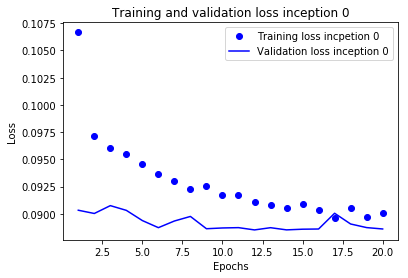

<Figure size 432x288 with 0 Axes>

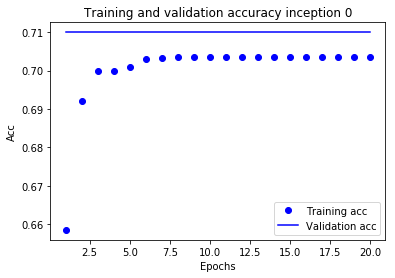

In [0]:
loss0 = history_inception0.history['loss']
val_loss0 = history_inception0.history['val_loss']

epochs0 = range(1,len(loss0)+1)

plt.figure()
plt.plot(epochs0,loss0,'bo',label='Training loss incpetion 0')
plt.plot(epochs0,val_loss0,'b',label='Validation loss inception 0')
plt.title('Training and validation loss inception 0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()


plt.figure()
acc0 = history_inception0.history['acc']
val_acc0 = history_inception0.history['val_acc']
plt.plot(epochs0, acc0, 'bo', label='Training acc')
plt.plot(epochs0, val_acc0, 'b', label='Validation acc')
plt.title('Training and validation accuracy inception 0')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [0]:
Y0_pred = model_inception0.predict(X0_val)

Y56_pred = model_inception56.predict(X56_val)

Y112_pred = model_inception112.predict(X112_val)

Ensemble all inception frames

In [0]:
Y_inception_pred_val =(Y0_pred+ Y56_pred+ Y112_pred)/3

## Get Results

In [0]:
#individual results
Get_score(Y0_pred,Y_val)

Get_score(Y56_pred,Y_val)

Get_score(Y112_pred,Y_val)

The Spearman's correlation coefficient is: 0.118
The Spearman's correlation coefficient is: 0.068
The Spearman's correlation coefficient is: 0.101
The Spearman's correlation coefficient is: 0.058
The Spearman's correlation coefficient is: 0.161
The Spearman's correlation coefficient is: 0.135


In [0]:
#total inception results
Get_score(Y_inception_pred_val,Y_val)

The Spearman's correlation coefficient is: 0.130
The Spearman's correlation coefficient is: 0.097


In [0]:
inception_prediction = Y_inception_pred_val

# Ensamble results

In [0]:
#all features
print("HMP + C3D + Caption-onehot + caption-embedding + caption-recurrent + LBP + inception")
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/7
Get_score(Y_ensamble_pred, Y_val)

#all without recurrent feature
print("HMP + C3D + Caption-onehot + caption-embedding + LBP + inception  #without recurrent")
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)


#all without recurrent feature and lbp
print("HMP + C3D + Caption-onehot + caption-embedding + inception  #without recurrent and LBP")
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/5
Get_score(Y_ensamble_pred, Y_val)


HMP + C3D + Caption-onehot + caption-embedding + caption-recurrent + LBP + inception
The Spearman's correlation coefficient is: 0.455
The Spearman's correlation coefficient is: 0.195
HMP + C3D + Caption-onehot + caption-embedding + LBP + inception  #without recurrent
The Spearman's correlation coefficient is: 0.467
The Spearman's correlation coefficient is: 0.200
HMP + C3D + Caption-onehot + caption-embedding + inception  #without recurrent and LBP
The Spearman's correlation coefficient is: 0.473
The Spearman's correlation coefficient is: 0.200


Seems like the model without LBP+recurrent is performing better.

# Ensamble technique

Adding all predictions

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/7
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.455
The Spearman's correlation coefficient is: 0.195


### Without HMP

In [0]:
Y_ensamble_pred = c3d_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.450
The Spearman's correlation coefficient is: 0.189


### Without C3D

In [0]:
Y_ensamble_pred = hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.446
The Spearman's correlation coefficient is: 0.188


### Without caption-oneHotEncoding

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+embedding_prediction+recurrent_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.424
The Spearman's correlation coefficient is: 0.177


### Without caption-embedding

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+recurrent_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.442
The Spearman's correlation coefficient is: 0.203


### Without caption-recurrent

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+lbp_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.467
The Spearman's correlation coefficient is: 0.200


## Without lbp

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.457
The Spearman's correlation coefficient is: 0.194


## Without inception

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+recurrent_prediction+lbp_prediction
Y_ensamble_pred = Y_ensamble_pred/6
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.453
The Spearman's correlation coefficient is: 0.192


## Without caption-recurrent and LBP

In [0]:
Y_ensamble_pred = c3d_prediction+hmp_prediction+caption_onehot_prediction+embedding_prediction+inception_prediction
Y_ensamble_pred = Y_ensamble_pred/5
Get_score(Y_ensamble_pred, Y_val)

The Spearman's correlation coefficient is: 0.473
The Spearman's correlation coefficient is: 0.200


This is the best result so far

## Bagging with max approach 

In [0]:
Y_ensamble_max = np.maximum.reduce([ c3d_prediction,hmp_prediction,caption_onehot_prediction,embedding_prediction,recurrent_prediction,lbp_prediction,inception_prediction])
Get_score(Y_ensamble_pred,Y_val)

The Spearman's correlation coefficient is: 0.473
The Spearman's correlation coefficient is: 0.200


## Combination of models to ensamble(Avg)

In [0]:
import itertools
predictions = [{"strValue": "c3d_prediction","model": c3d_prediction},
               {"strValue": "hmp_prediction","model": hmp_prediction},
               {"strValue": "caption_onehot_prediction","model": caption_onehot_prediction},
               {"strValue": "embedding_prediction","model": embedding_prediction},
               {"strValue": "recurrent_prediction","model": recurrent_prediction},
               {"strValue": "lbp_prediction","model": lbp_prediction},
               {"strValue": "inception_prediction","model": inception_prediction}]
counts, final = len(predictions), []
for i in range(3,counts):
  for m in itertools.permutations(predictions, i):
    allModels, tmp_ensamble, count = "", np.zeros(m[0]["model"].shape), 0
    for item in m:
      allModels += item["strValue"]
      count=count+1
      if count < len(m):
         allModels += ", "
      tmp_ensamble  = tmp_ensamble+item["model"]
    result = round(Get_score_value(tmp_ensamble/len(m),Y_val),4)
    final.append({"score":result,"models":allModels})
scores_sorted = sorted(final, key=lambda x: x["score"],reverse=True)

In [0]:
print(*scores_sorted[20:],sep="\n")

{'score': 0.4732, 'models': 'c3d_prediction, inception_prediction, caption_onehot_prediction, hmp_prediction, embedding_prediction'}
{'score': 0.4732, 'models': 'c3d_prediction, inception_prediction, caption_onehot_prediction, embedding_prediction, hmp_prediction'}
{'score': 0.4732, 'models': 'c3d_prediction, inception_prediction, embedding_prediction, hmp_prediction, caption_onehot_prediction'}
{'score': 0.4732, 'models': 'c3d_prediction, inception_prediction, embedding_prediction, caption_onehot_prediction, hmp_prediction'}
{'score': 0.4732, 'models': 'hmp_prediction, c3d_prediction, caption_onehot_prediction, embedding_prediction, inception_prediction'}
{'score': 0.4732, 'models': 'hmp_prediction, c3d_prediction, caption_onehot_prediction, inception_prediction, embedding_prediction'}
{'score': 0.4732, 'models': 'hmp_prediction, c3d_prediction, embedding_prediction, caption_onehot_prediction, inception_prediction'}
{'score': 0.4732, 'models': 'hmp_prediction, c3d_prediction, embeddin

{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, c3d_prediction, caption_onehot_prediction, embedding_prediction, lbp_prediction'}
{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, c3d_prediction, caption_onehot_prediction, lbp_prediction, embedding_prediction'}
{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, c3d_prediction, embedding_prediction, caption_onehot_prediction, lbp_prediction'}
{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, c3d_prediction, embedding_prediction, lbp_prediction, caption_onehot_prediction'}
{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, c3d_prediction, lbp_prediction, caption_onehot_prediction, embedding_prediction'}
{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, c3d_prediction, lbp_prediction, embedding_prediction, caption_onehot_prediction'}
{'score': 0.4526, 'models': 'hmp_prediction, recurrent_prediction, caption_onehot_prediction, c3d_predicti

{'score': 0.4458, 'models': 'recurrent_prediction, inception_prediction, hmp_prediction, embedding_prediction, caption_onehot_prediction, lbp_prediction'}
{'score': 0.4458, 'models': 'recurrent_prediction, inception_prediction, hmp_prediction, embedding_prediction, lbp_prediction, caption_onehot_prediction'}
{'score': 0.4458, 'models': 'recurrent_prediction, inception_prediction, hmp_prediction, lbp_prediction, caption_onehot_prediction, embedding_prediction'}
{'score': 0.4458, 'models': 'recurrent_prediction, inception_prediction, hmp_prediction, lbp_prediction, embedding_prediction, caption_onehot_prediction'}
{'score': 0.4458, 'models': 'recurrent_prediction, inception_prediction, caption_onehot_prediction, hmp_prediction, embedding_prediction, lbp_prediction'}
{'score': 0.4458, 'models': 'recurrent_prediction, inception_prediction, caption_onehot_prediction, hmp_prediction, lbp_prediction, embedding_prediction'}
{'score': 0.4458, 'models': 'recurrent_prediction, inception_predictio

{'score': 0.4336, 'models': 'hmp_prediction, lbp_prediction, recurrent_prediction, inception_prediction, caption_onehot_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, lbp_prediction, inception_prediction, caption_onehot_prediction, recurrent_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, lbp_prediction, inception_prediction, recurrent_prediction, caption_onehot_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, inception_prediction, caption_onehot_prediction, recurrent_prediction, lbp_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, inception_prediction, caption_onehot_prediction, lbp_prediction, recurrent_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, inception_prediction, recurrent_prediction, caption_onehot_prediction, lbp_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, inception_prediction, recurrent_prediction, lbp_prediction, caption_onehot_prediction'}
{'score': 0.4336, 'models': 'hmp_prediction, inception_prediction, lb

{'score': 0.387, 'models': 'lbp_prediction, recurrent_prediction, inception_prediction, hmp_prediction, c3d_prediction'}
{'score': 0.387, 'models': 'lbp_prediction, inception_prediction, c3d_prediction, hmp_prediction, recurrent_prediction'}
{'score': 0.387, 'models': 'lbp_prediction, inception_prediction, c3d_prediction, recurrent_prediction, hmp_prediction'}
{'score': 0.387, 'models': 'lbp_prediction, inception_prediction, hmp_prediction, c3d_prediction, recurrent_prediction'}
{'score': 0.387, 'models': 'lbp_prediction, inception_prediction, hmp_prediction, recurrent_prediction, c3d_prediction'}
{'score': 0.387, 'models': 'lbp_prediction, inception_prediction, recurrent_prediction, c3d_prediction, hmp_prediction'}
{'score': 0.387, 'models': 'lbp_prediction, inception_prediction, recurrent_prediction, hmp_prediction, c3d_prediction'}
{'score': 0.387, 'models': 'inception_prediction, c3d_prediction, hmp_prediction, recurrent_prediction, lbp_prediction'}
{'score': 0.387, 'models': 'ince

From the above, we can deduce that LBP and Caption-recurrent is not leading to the models giving the top results. The features that are contributing are 
  - HMP
  - C3D
  - With caption, Embedding approach
  - With caption, one hot encoding approach
  - Inception

Lets use thse models together, we will get the following score

In [0]:
best_avg = (c3d_prediction+ inception_prediction+ caption_onehot_prediction+ hmp_prediction+ embedding_prediction)/5
Get_score(best_avg,Y_val)

The Spearman's correlation coefficient is: 0.473
The Spearman's correlation coefficient is: 0.200


From the above, we observe th score to be .473 and .200

## Ensamble all with weighted avg


From the above analysis with avg ensambled results, we have identified the following models **HMP, C3D, caption-embedding, caption-oneHotEncoding and inception** are the one's contributing towards the final score with the highest ( and second highest ) maximum score. Lets try some solutions with the above models and weight avg ensamble approach

In [0]:
import itertools
predictions = [{"strValue": "c3d_prediction","model": c3d_prediction},
               {"strValue": "hmp_prediction","model": hmp_prediction},
               {"strValue": "caption_onehot_prediction","model": caption_onehot_prediction},
               {"strValue": "embedding_prediction","model": embedding_prediction},
               {"strValue": "recurrent_prediction","model": recurrent_prediction},
               {"strValue": "lbp_prediction","model": lbp_prediction},
               {"strValue": "inception_prediction","model": inception_prediction}]
counts = len(predictions)
final = []
weights= {
    3:[.30,.30,.4],
    4:[.15,.20,.30,.35],
    5:[.10,.15,.20,.20,.25],
    6:[.10,.10,.15,.20,.20,0.25],
}
for i in range(3,counts):
  for m in itertools.permutations(predictions, i):
    allModels = []
    tmp_ensamble = np.zeros(m[0]["model"].shape) 
    count = 0
    total_no_of_items = len(m)
    trial_weights = weights[total_no_of_items]
    for item in m:
      allModels.append(item["strValue"]+"*" + str(trial_weights[count]))
      tmp_ensamble  = tmp_ensamble+(item["model"]*trial_weights[count])
      count=count+1
    result = round(Get_score_value(tmp_ensamble,Y_val),4)
    final.append({"score":result,"models":", ".join(allModels)})
scores_sorted = sorted(final, key=lambda x: x["score"],reverse=True)

In [0]:
print(*scores_sorted[20:],sep="\n")

{'score': 0.4749, 'models': 'hmp_prediction*0.1, lbp_prediction*0.1, c3d_prediction*0.15, embedding_prediction*0.2, inception_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4749, 'models': 'hmp_prediction*0.1, lbp_prediction*0.1, c3d_prediction*0.15, inception_prediction*0.2, embedding_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4749, 'models': 'lbp_prediction*0.1, hmp_prediction*0.1, c3d_prediction*0.15, embedding_prediction*0.2, inception_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4749, 'models': 'lbp_prediction*0.1, hmp_prediction*0.1, c3d_prediction*0.15, inception_prediction*0.2, embedding_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4748, 'models': 'c3d_prediction*0.1, embedding_prediction*0.15, hmp_prediction*0.2, caption_onehot_prediction*0.2, inception_prediction*0.25'}
{'score': 0.4748, 'models': 'c3d_prediction*0.1, embedding_prediction*0.15, caption_onehot_prediction*0.2, hmp_prediction*0.2, inception_predicti

{'score': 0.4533, 'models': 'recurrent_prediction*0.1, c3d_prediction*0.1, inception_prediction*0.15, lbp_prediction*0.2, hmp_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4533, 'models': 'recurrent_prediction*0.1, inception_prediction*0.1, lbp_prediction*0.15, c3d_prediction*0.2, hmp_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4533, 'models': 'recurrent_prediction*0.1, inception_prediction*0.1, lbp_prediction*0.15, hmp_prediction*0.2, c3d_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4533, 'models': 'inception_prediction*0.1, recurrent_prediction*0.1, lbp_prediction*0.15, c3d_prediction*0.2, hmp_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4533, 'models': 'inception_prediction*0.1, recurrent_prediction*0.1, lbp_prediction*0.15, hmp_prediction*0.2, c3d_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4532, 'models': 'c3d_prediction*0.1, embedding_prediction*0.1, inception_prediction*0.15, hmp_prediction*0.2, rec

{'score': 0.4418, 'models': 'caption_onehot_prediction*0.15, recurrent_prediction*0.2, c3d_prediction*0.3, embedding_prediction*0.35'}
{'score': 0.4418, 'models': 'hmp_prediction*0.1, lbp_prediction*0.15, c3d_prediction*0.2, recurrent_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4418, 'models': 'hmp_prediction*0.1, lbp_prediction*0.15, recurrent_prediction*0.2, c3d_prediction*0.2, caption_onehot_prediction*0.25'}
{'score': 0.4418, 'models': 'caption_onehot_prediction*0.1, embedding_prediction*0.15, hmp_prediction*0.2, recurrent_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4418, 'models': 'caption_onehot_prediction*0.1, embedding_prediction*0.15, recurrent_prediction*0.2, hmp_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4418, 'models': 'caption_onehot_prediction*0.1, recurrent_prediction*0.15, hmp_prediction*0.2, embedding_prediction*0.2, inception_prediction*0.25'}
{'score': 0.4418, 'models': 'caption_onehot_prediction*0.1, recurrent_prediction*0.15, embedding

{'score': 0.4268, 'models': 'c3d_prediction*0.1, inception_prediction*0.1, caption_onehot_prediction*0.15, hmp_prediction*0.2, lbp_prediction*0.2, recurrent_prediction*0.25'}
{'score': 0.4268, 'models': 'c3d_prediction*0.1, inception_prediction*0.1, caption_onehot_prediction*0.15, lbp_prediction*0.2, hmp_prediction*0.2, recurrent_prediction*0.25'}
{'score': 0.4268, 'models': 'caption_onehot_prediction*0.1, lbp_prediction*0.1, recurrent_prediction*0.15, hmp_prediction*0.2, inception_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4268, 'models': 'caption_onehot_prediction*0.1, lbp_prediction*0.1, recurrent_prediction*0.15, inception_prediction*0.2, hmp_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4268, 'models': 'lbp_prediction*0.1, caption_onehot_prediction*0.1, recurrent_prediction*0.15, hmp_prediction*0.2, inception_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4268, 'models': 'lbp_prediction*0.1, caption_onehot_prediction*0.1, recurrent_prediction*0.15, inception_predicti

{'score': 0.4087, 'models': 'hmp_prediction*0.1, embedding_prediction*0.1, lbp_prediction*0.15, recurrent_prediction*0.2, inception_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4087, 'models': 'hmp_prediction*0.1, embedding_prediction*0.1, lbp_prediction*0.15, inception_prediction*0.2, recurrent_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4087, 'models': 'embedding_prediction*0.1, hmp_prediction*0.1, lbp_prediction*0.15, recurrent_prediction*0.2, inception_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4087, 'models': 'embedding_prediction*0.1, hmp_prediction*0.1, lbp_prediction*0.15, inception_prediction*0.2, recurrent_prediction*0.2, c3d_prediction*0.25'}
{'score': 0.4086, 'models': 'caption_onehot_prediction*0.15, inception_prediction*0.2, c3d_prediction*0.3, recurrent_prediction*0.35'}
{'score': 0.4086, 'models': 'lbp_prediction*0.15, embedding_prediction*0.2, hmp_prediction*0.3, inception_prediction*0.35'}
{'score': 0.4086, 'models': 'hmp_prediction*0.1, recurrent_pr

We see an improvement in the score .i.e, .4763 is the new best score

In [0]:
best_score = hmp_prediction*0.1+ lbp_prediction*0.1+ c3d_prediction*0.15+ embedding_prediction*0.2+ inception_prediction*0.2+ caption_onehot_prediction*0.25
Get_score(best_score,Y_val)

The Spearman's correlation coefficient is: 0.475
The Spearman's correlation coefficient is: 0.196


Trying the above given weights will give us a result of .475 .for short term and .196 for long term

Lets change the averages to more aggressive and try once more

In [0]:
import itertools
predictions = [{"strValue": "c3d_prediction","model": c3d_prediction},
               {"strValue": "hmp_prediction","model": hmp_prediction},
               {"strValue": "caption_onehot_prediction","model": caption_onehot_prediction},
               {"strValue": "embedding_prediction","model": embedding_prediction},
               {"strValue": "recurrent_prediction","model": recurrent_prediction},
               {"strValue": "lbp_prediction","model": lbp_prediction},
               {"strValue": "inception_prediction","model": inception_prediction}]
counts = len(predictions)
final = []
weights= {
    3:[.10,.10,.8],
    4:[.05,.10,.12,.73],
    5:[.05,0.05,.10,.10,.7],
    6:[.05,.05,.1,.10,.2,0.5],
}
for i in range(3,counts):
  for m in itertools.permutations(predictions, i):
    allModels = []
    tmp_ensamble = np.zeros(m[0]["model"].shape) 
    count = 0
    total_no_of_items = len(m)
    trial_weights = weights[total_no_of_items]
    for item in m:
      allModels.append(item["strValue"]+"*" + str(trial_weights[count]))
      tmp_ensamble  = tmp_ensamble+(item["model"]*trial_weights[count])
      count=count+1
    result = round(Get_score_value(tmp_ensamble/len(m),Y_val),4)
    final.append({"score":result,"models":", ".join(allModels)})
scores_sorted = sorted(final, key=lambda x: x["score"],reverse=True)

In [0]:
print(*scores_sorted[20:],sep="\n")

{'score': 0.4651, 'models': 'lbp_prediction*0.05, hmp_prediction*0.05, c3d_prediction*0.1, inception_prediction*0.1, embedding_prediction*0.2, caption_onehot_prediction*0.5'}
{'score': 0.4651, 'models': 'lbp_prediction*0.05, hmp_prediction*0.05, inception_prediction*0.1, c3d_prediction*0.1, embedding_prediction*0.2, caption_onehot_prediction*0.5'}
{'score': 0.4651, 'models': 'inception_prediction*0.05, recurrent_prediction*0.05, hmp_prediction*0.1, embedding_prediction*0.1, c3d_prediction*0.2, caption_onehot_prediction*0.5'}
{'score': 0.4651, 'models': 'inception_prediction*0.05, recurrent_prediction*0.05, embedding_prediction*0.1, hmp_prediction*0.1, c3d_prediction*0.2, caption_onehot_prediction*0.5'}
{'score': 0.465, 'models': 'hmp_prediction*0.05, inception_prediction*0.05, embedding_prediction*0.1, lbp_prediction*0.1, c3d_prediction*0.2, caption_onehot_prediction*0.5'}
{'score': 0.465, 'models': 'hmp_prediction*0.05, inception_prediction*0.05, lbp_prediction*0.1, embedding_predicti

{'score': 0.4313, 'models': 'embedding_prediction*0.05, lbp_prediction*0.05, inception_prediction*0.1, recurrent_prediction*0.1, caption_onehot_prediction*0.2, c3d_prediction*0.5'}
{'score': 0.4313, 'models': 'recurrent_prediction*0.05, caption_onehot_prediction*0.05, lbp_prediction*0.1, inception_prediction*0.1, c3d_prediction*0.2, embedding_prediction*0.5'}
{'score': 0.4313, 'models': 'recurrent_prediction*0.05, caption_onehot_prediction*0.05, inception_prediction*0.1, lbp_prediction*0.1, c3d_prediction*0.2, embedding_prediction*0.5'}
{'score': 0.4313, 'models': 'lbp_prediction*0.05, embedding_prediction*0.05, recurrent_prediction*0.1, inception_prediction*0.1, caption_onehot_prediction*0.2, c3d_prediction*0.5'}
{'score': 0.4313, 'models': 'lbp_prediction*0.05, embedding_prediction*0.05, inception_prediction*0.1, recurrent_prediction*0.1, caption_onehot_prediction*0.2, c3d_prediction*0.5'}
{'score': 0.4312, 'models': 'hmp_prediction*0.05, caption_onehot_prediction*0.05, recurrent_pre

{'score': 0.4035, 'models': 'recurrent_prediction*0.05, hmp_prediction*0.05, c3d_prediction*0.1, inception_prediction*0.1, embedding_prediction*0.2, lbp_prediction*0.5'}
{'score': 0.4035, 'models': 'recurrent_prediction*0.05, hmp_prediction*0.05, inception_prediction*0.1, c3d_prediction*0.1, embedding_prediction*0.2, lbp_prediction*0.5'}
{'score': 0.4035, 'models': 'lbp_prediction*0.05, c3d_prediction*0.05, hmp_prediction*0.1, inception_prediction*0.1, recurrent_prediction*0.2, embedding_prediction*0.5'}
{'score': 0.4035, 'models': 'lbp_prediction*0.05, c3d_prediction*0.05, inception_prediction*0.1, hmp_prediction*0.1, recurrent_prediction*0.2, embedding_prediction*0.5'}
{'score': 0.4035, 'models': 'inception_prediction*0.05, c3d_prediction*0.05, hmp_prediction*0.1, lbp_prediction*0.1, recurrent_prediction*0.2, embedding_prediction*0.5'}
{'score': 0.4035, 'models': 'inception_prediction*0.05, c3d_prediction*0.05, embedding_prediction*0.1, lbp_prediction*0.1, recurrent_prediction*0.2, h

{'score': 0.378, 'models': 'caption_onehot_prediction*0.05, c3d_prediction*0.05, embedding_prediction*0.1, inception_prediction*0.1, hmp_prediction*0.2, recurrent_prediction*0.5'}
{'score': 0.378, 'models': 'caption_onehot_prediction*0.05, c3d_prediction*0.05, inception_prediction*0.1, embedding_prediction*0.1, hmp_prediction*0.2, recurrent_prediction*0.5'}
{'score': 0.378, 'models': 'embedding_prediction*0.05, hmp_prediction*0.05, c3d_prediction*0.1, inception_prediction*0.1, recurrent_prediction*0.2, lbp_prediction*0.5'}
{'score': 0.378, 'models': 'embedding_prediction*0.05, hmp_prediction*0.05, inception_prediction*0.1, c3d_prediction*0.1, recurrent_prediction*0.2, lbp_prediction*0.5'}
{'score': 0.3779, 'models': 'recurrent_prediction*0.05, lbp_prediction*0.05, embedding_prediction*0.1, inception_prediction*0.1, hmp_prediction*0.7'}
{'score': 0.3779, 'models': 'recurrent_prediction*0.05, lbp_prediction*0.05, inception_prediction*0.1, embedding_prediction*0.1, hmp_prediction*0.7'}
{'

{'score': 0.3331, 'models': 'recurrent_prediction*0.05, embedding_prediction*0.05, inception_prediction*0.1, hmp_prediction*0.1, lbp_prediction*0.7'}
{'score': 0.3328, 'models': 'c3d_prediction*0.1, embedding_prediction*0.1, lbp_prediction*0.8'}
{'score': 0.3328, 'models': 'embedding_prediction*0.1, c3d_prediction*0.1, lbp_prediction*0.8'}
{'score': 0.3327, 'models': 'caption_onehot_prediction*0.1, inception_prediction*0.1, recurrent_prediction*0.8'}
{'score': 0.3327, 'models': 'inception_prediction*0.1, caption_onehot_prediction*0.1, recurrent_prediction*0.8'}
{'score': 0.3326, 'models': 'embedding_prediction*0.05, recurrent_prediction*0.1, inception_prediction*0.12, lbp_prediction*0.73'}
{'score': 0.3325, 'models': 'hmp_prediction*0.05, embedding_prediction*0.1, lbp_prediction*0.12, inception_prediction*0.73'}
{'score': 0.3324, 'models': 'c3d_prediction*0.05, lbp_prediction*0.05, embedding_prediction*0.1, inception_prediction*0.1, recurrent_prediction*0.7'}
{'score': 0.3324, 'models'

In [0]:
best_aggressive = lbp_prediction*0.05+ inception_prediction*0.05+ c3d_prediction*0.1+ hmp_prediction*0.1+ embedding_prediction*0.2+ caption_onehot_prediction*0.5
Get_score(best_aggressive,Y_val)

The Spearman's correlation coefficient is: 0.466
The Spearman's correlation coefficient is: 0.193


We can see a further improvement of .466 and .193 in both short and long term scores.

# Predict on the test set

In [0]:
!ls "/kaggle/input/memtest/test-set/test-set"

C3D_test	     Inception_test  aesthetic_vis_features_test
ColorHistogram_test  LBP_test	     ground_truth_template.csv
HMP_test	     ORB_test	     test-set-1_video-captions.txt
HOG_test	     README.txt


In [0]:
testset = "/kaggle/input/memtest/test-set/test-set/"

In [0]:
test_labels=pd.read_csv(testset+'ground_truth_template.csv')
test_labels.head()

video            ...             nb_long-term_annotations
0   7494            ...                                   12
1   7495            ...                                   10
2   7496            ...                                   13
3   7497            ...                                   10
4   7498            ...                                   10

[5 rows x 5 columns]

### Check the total no of videos

In [0]:
vid = test_labels.video.values
len(vid)

2000

### Read and predict HMP

In [0]:
os.chdir(testset)
test_hmp = pd.DataFrame({'video': vid, 'HMP': [read_HMP('./HMP_test/video'+str(item)+'.txt') for item in vid]})
test_hmp.head()

video                                                HMP
0   7494  [0.022039, 0.005264, 9.8e-05, 0.0, 0.003689, 0...
1   7495  [0.004694, 0.001934, 4e-05, 0.0, 0.001226, 5.8...
2   7496  [0.02653, 0.006208, 5.8e-05, 0.0, 0.00228, 3.1...
3   7497  [0.045109, 0.008317, 0.000151, 0.0, 0.005598, ...
4   7498  [0.034691, 0.008619, 0.000412, 0.0, 0.028355, ...

In [0]:
 X_test = np.stack(test_hmp['HMP'].values)

In [0]:
test_hmp_prediction = model_hmp.predict(X_test)

### Read and predict C3D

In [0]:
test_c3d = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D('./C3D_test/video'+str(item)+'.txt') for item in vid],
                       })

In [0]:
test_c3d.head()

video                                                C3D
0   7494  [0.00013576, 0.0002133, 0.00124759, 1.149e-05,...
1   7495  [0.00012659, 2.377e-05, 0.04950115, 2.418e-05,...
2   7496  [0.48898152, 0.00058536, 2.454e-05, 0.00016031...
3   7497  [0.24925078, 0.00101763, 8.02e-06, 1.92e-05, 2...
4   7498  [0.00989415, 3.413e-05, 0.00261261, 2.1e-06, 1...

In [0]:
X_test_c3d = np.stack(test_c3d['C3D'].values)

In [0]:
test_c3d_prediction = modelc3d.predict(X_test_c3d)

### Read and predict captions

With OneHotEncoding

In [0]:
test_cap_path = 'test-set-1_video-captions.txt'
df_cap_test=read_caps(test_cap_path)
df_cap_test.head()

video                                            caption
0  video7494.webm     green-jeep-struggling-to-drive-over-huge-rocks
1  video7495.webm  hiking-woman-tourist-is-walking-forward-in-mou...
2  video7496.webm  close-up-of-african-american-doctors-hands-usi...
3  video7497.webm  slow-motion-of-a-man-using-treadmill-in-the-gy...
4  video7498.webm       slow-motion-of-photographer-in-national-park

In [0]:
X_test_onehot = tokenizer.texts_to_matrix(list(df_cap_test.caption.values),mode='binary')

In [0]:
test_onehot_prediction = model_onehot.predict(X_test_onehot)

With embedding

In [0]:
#setup the counter to check the progress
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap_test['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap_test['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap_test.loc[i,'caption'] =  text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [0]:
test_len=np.zeros(len(df_cap_test))
for ii in range(len(df_cap_test)):
    text = df_cap_test.caption[ii]
    test_len[ii]=len(text.split())

In [0]:
maxlen_test = int(max(test_len))

In [0]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_cap_test.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_cap_test.caption.values))
maxlen = 20
X_embedding_test = preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)

In [0]:
test_embedding_prediction = model_embedding.predict(X_embedding_test)

With RNN

In [0]:
 test_rnn_prediction = model_rnn.predict(X_embedding_test)

## Read and predict LBP

In [0]:
test_lbp_56 = pd.DataFrame({'video': vid, 'LBP': [read_LBP('./LBP_test/video'+str(item)+"-56.txt") for item in vid]})
test_lbp_112 = pd.DataFrame({'video': vid, 'LBP': [read_LBP('./LBP_test/video'+str(item)+"-112.txt") for item in vid]})

In [0]:
X_lbp_56_test = np.stack(test_lbp_56["LBP"].values)
X_lbp_112_test = np.stack(test_lbp_112["LBP"].values)

In [0]:
test_lbp56_prediction = model_lbp56.predict(X_lbp_56_test)
test_lbp112_prediction = model_lbp112.predict(X_lbp_112_test)

In [0]:
test_lbp_prediction = (test_lbp56_prediction+test_lbp112_prediction)/2

## Read and predict inception

In [0]:
#load from data from each frame
test_inception_0 = pd.DataFrame({'video': vid,
                   'inception': [read_inception('./Inception_test/video'+str(item)+'-0.txt') for item in vid]})
test_inception_56 = pd.DataFrame({'video': vid,
                   'inception': [read_inception('./Inception_test/video'+str(item)+'-56.txt') for item in vid]})
test_inception_112 = pd.DataFrame({'video': vid,
                   'inception': [read_inception('./Inception_test/video'+str(item)+'-112.txt') for item in vid]})

In [0]:
test_inception0 = np.stack(test_inception_0["inception"].values)
test_inception56 = np.stack(test_inception_56["inception"].values)
test_inception112 = np.stack(test_inception_112["inception"].values)


In [0]:
inception0_prediction = model_inception0.predict(test_inception0)
inception56_prediction = model_inception56.predict(test_inception56)
inception112_prediction = model_inception112.predict(test_inception112)

In [0]:
inception_prediction = (inception0_prediction+inception56_prediction+inception112_prediction)/3

## Ensamble all

In [0]:
best_test_avg = inception_prediction+test_lbp_prediction+test_rnn_prediction+test_onehot_prediction+test_c3d_prediction+test_hmp_prediction+test_embedding_prediction

According to our earlier analysis, we have our best performing bagging approach to be with custom weight. 

In [0]:
best_wight_avg = test_hmp_prediction*0.1+ test_lbp_prediction*0.1+ test_c3d_prediction*0.15+ test_embedding_prediction*0.2+ inception_prediction*0.2+ test_onehot_prediction*0.25

In [0]:
best_wight_avg

array([[0.8473398 , 0.7532873 ],
       [0.85647905, 0.76126707],
       [0.8837413 , 0.8074571 ],
       ...,
       [0.8878275 , 0.7926289 ],
       [0.88953704, 0.8099591 ],
       [0.8871186 , 0.7785183 ]], dtype=float32)

In [0]:
test_labels_result =pd.read_csv(testset+'ground_truth_template.csv')
test_labels_result.head()

video            ...             nb_long-term_annotations
0   7494            ...                                   12
1   7495            ...                                   10
2   7496            ...                                   13
3   7497            ...                                   10
4   7498            ...                                   10

[5 rows x 5 columns]

In [0]:
test_labels_result["short-term_memorability"] = best_wight_avg[:,0]
test_labels_result["long-term_memorability"] = best_wight_avg[:,1]
test_labels_result.head()

video            ...             nb_long-term_annotations
0   7494            ...                                   12
1   7495            ...                                   10
2   7496            ...                                   13
3   7497            ...                                   10
4   7498            ...                                   10

[5 rows x 5 columns]

In [0]:
os.chdir('/kaggle/working/')
from IPython.display import HTML
import pandas as pd
import numpy as np

test_labels_result.to_csv('submission.csv')

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')